In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [48]:
qqq = pd.read_csv('data\QQQ_1H_6sma_Jul24.csv')
# spy = pd.read_csv('data\SPY_1H_UNIX_6sma.csv')

new_names = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
to_rename = ['MA', 'MA.1', 'MA.2', 'MA.3', 'MA.4', 'MA.5']

qqq.rename(columns = dict(zip(to_rename, new_names)), inplace = True)
# spy.rename(columns = dict(zip(to_rename, new_names)), inplace = True)

# Converting from UNIX to readable datetime
qqq.time = pd.to_datetime(qqq.time, utc = True)
# spy.time = pd.to_datetime(spy.time, unit = 's')

qqq

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume
0,2018-01-02 12:00:00+00:00,156.08,156.36,156.080,156.35,NaN,NaN,NaN,NaN,NaN,NaN,3900
1,2018-01-02 13:00:00+00:00,156.38,156.44,156.320,156.43,NaN,NaN,NaN,NaN,NaN,NaN,9000
2,2018-01-02 14:00:00+00:00,156.41,157.52,156.170,157.49,NaN,NaN,NaN,NaN,NaN,NaN,564693
3,2018-01-02 15:00:00+00:00,157.48,157.97,157.470,157.96,NaN,NaN,NaN,NaN,NaN,NaN,554058
4,2018-01-02 16:00:00+00:00,157.96,158.15,157.895,157.98,NaN,NaN,NaN,NaN,NaN,157.242,270979
...,...,...,...,...,...,...,...,...,...,...,...,...
21063,2024-07-12 19:00:00+00:00,498.89,498.94,494.110,494.88,488.80966,496.52408,497.71088,493.7655,495.496,497.156,1403844
21064,2024-07-12 20:00:00+00:00,494.86,495.32,494.500,494.84,488.90276,496.59608,497.65548,493.8920,495.761,496.896,97970
21065,2024-07-12 21:00:00+00:00,494.81,494.85,494.520,494.85,488.99586,496.65888,497.59688,494.0825,495.991,496.466,7322
21066,2024-07-12 22:00:00+00:00,494.85,494.95,494.850,494.95,489.09131,496.70683,497.53668,494.1860,496.241,495.684,2786


# EDA

In [28]:
# Check for nulls
# print(qqq[pd.isnull(qqq).any(axis = 1)])
# print(spy[pd.isnull(spy).any(axis = 1)])

# Both dataframes contains a couple hundred rows containing at least 1 null value
# This is due to the data source (Tradingview) only keeping hourly SMA data from about Jan 30, 2018 onwards
# Will get rid of these rows, only a month of data

# qqq = qqq.dropna()
# spy = spy.dropna()

In [30]:
# print(f'QQQ\n{qqq.describe()}')
# print('\n\nSpy')
# print(spy.describe())

C:\Users\yangt\AppData\Local\Temp\ipykernel_2512\129467422.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  qqq_daily = qqq.groupby(qqq['time'].dt.to_period('D')).last()


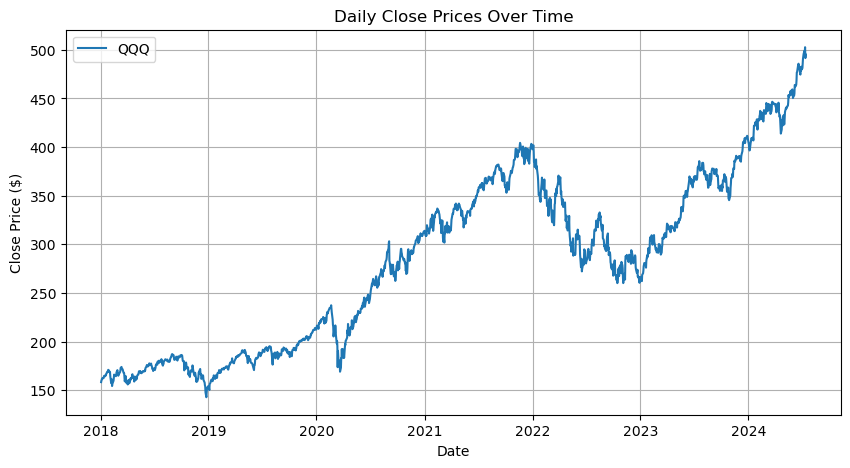

In [52]:
# Grouping by day
qqq_daily = qqq.groupby(qqq['time'].dt.to_period('D')).last()
# spy_daily = spy.groupby(spy['time'].dt.to_period('D')).last()

# Plotting the performance over time
plt.figure(figsize = (10,5))

plt.plot(qqq_daily['time'], qqq_daily['close'], label = 'QQQ')
# plt.plot(spy_daily['time'], spy_daily['close'], label = 'SPY')
plt.title('Daily Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.legend()

plt.show()

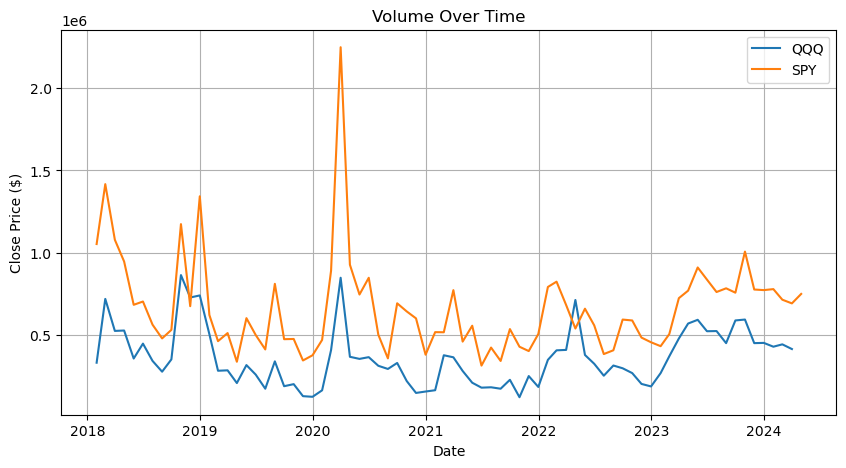

In [81]:
# Monthly volume
qqq_monthly_vol = qqq.groupby(pd.Grouper(key = 'time', freq = 'M')).mean()['Volume']
spy_monthly_vol = spy.groupby(pd.Grouper(key = 'time', freq = 'M')).mean()['Volume']

qqq_monthly_vol = qqq_monthly_vol.reset_index()
spy_monthly_vol = spy_monthly_vol.reset_index()

plt.figure(figsize = (10,5))

plt.plot(qqq_monthly_vol['time'], qqq_monthly_vol['Volume'], label = 'QQQ')
plt.plot(spy_monthly_vol['time'], spy_monthly_vol['Volume'], label = 'SPY')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.legend()

plt.show()

# Feature Engineering

In [69]:
# SMA slope
sma_cols = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
for sma in sma_cols:
    qqq[sma + '_1D_slope'] = qqq[sma].diff()
    # spy[sma + '_1D_slope'] = spy[sma].diff()
    
# Range between high and low - volatlity in the price swings
qqq['range_hi_lo'] = qqq['high'] - qqq['low']
# spy['range_hi_lo'] = spy['high'] - spy['low']

# range as a percentage of the close
qqq['range_%close'] = qqq['range_hi_lo']/qqq['close']
# spy['range_%close'] = spy['range_hi_lo']/spy['close']

# The slopes for the first entry will have NaN, replace with 0
# Some models will not accept any NaN values, so safer bet is to impute with 0
qqq = qqq.fillna(0)
spy = spy.fillna(0)

# Model - Linear Regression

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = qqq.drop(columns = ['close']).set_index('time')
Y = qqq[['time', 'close']].set_index('time')

x_train, x_test = X.iloc[:(int(len(X) * 0.4))], X.iloc[(int(len(X) * 0.4)):]
y_train, y_test = Y.iloc[:(int(len(Y) * 0.4))], Y.iloc[(int(len(Y) * 0.4)):]

LR = LinearRegression()

LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))
score = LR.score(x_test, y_test)

print(f'rmse = {rmse}\n\
score = {score}')

rmse = 0.46662784983033895
score = 0.9999235046243462


In [81]:
all_len = len(x_train) + len(x_test)
print(all_len)
print(len(x_train)/all_len)
print(len(x_test)/all_len)

21068
0.5999620277197646
0.4000379722802354
